In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/creidtcard/creditcard.csv


In [2]:
# ================================================================
#   STEP 1: IMPORT LIBRARIES
# ================================================================
import pandas as pd
import numpy as np

# ================================================================
#   STEP 2: LOAD DATASET
# ================================================================
# Make sure creditcard.csv is in the same folder as this script
df = pd.read_csv("/kaggle/input/creidtcard/creditcard.csv")

# ================================================================
#   STEP 3: BASIC DATA EXPLORATION
# ================================================================

print("\n===== FIRST 5 ROWS =====")
print(df.head())

print("\n===== LAST 5 ROWS =====")
print(df.tail())

print("\n===== DATASET SHAPE (rows, columns) =====")
print(df.shape)

print("\n===== DATA TYPES, NULL VALUES =====")
print(df.info())

print("\n===== STATISTICAL SUMMARY =====")
print(df.describe())

print("\n===== FRAUD CLASS COUNTS =====")
print(df['Class'].value_counts())

print("\n===== FRAUD CLASS DISTRIBUTION (%) =====")
print(df['Class'].value_counts(normalize=True) * 100)

print("\n===== CHECK FOR MISSING VALUES =====")
print(df.isnull().sum())



===== FIRST 5 ROWS =====
   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.206010   

      


Applying Mahalanobis SMOTE...
Applying ENN cleaning...

Training Logistic Regression...

Training KNN...

Training Random Forest...

=================== MODEL PERFORMANCE ===================

--- Logistic Regression ---
Accuracy: 0.9994
Precision: 0.9123
Recall: 0.8966
F1 Score: 0.9043
AUC: 0.9998
MCC: 0.9041

--- KNN ---
Accuracy: 0.9999
Precision: 0.9771
Recall: 0.9828
F1 Score: 0.9799
AUC: 1.0000
MCC: 0.9799

--- Random Forest ---
Accuracy: 0.9999
Precision: 0.9942
Recall: 0.9885
F1 Score: 0.9914
AUC: 1.0000
MCC: 0.9913


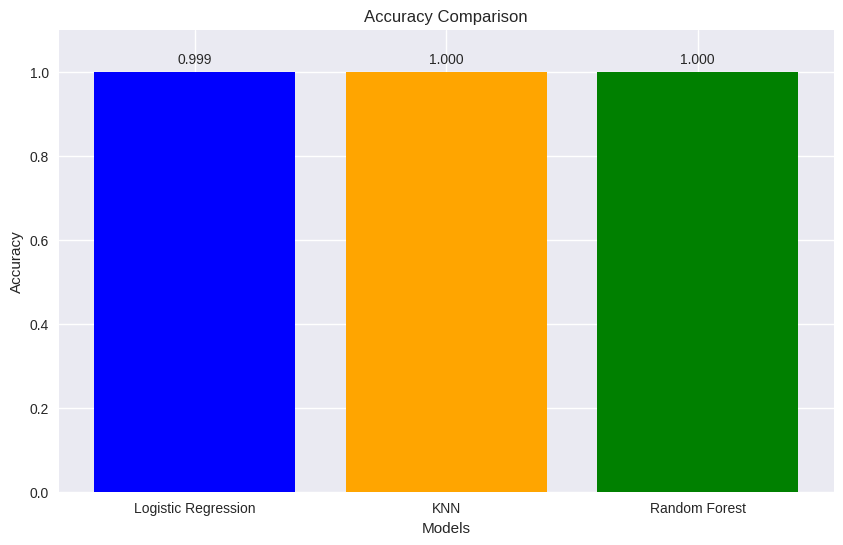

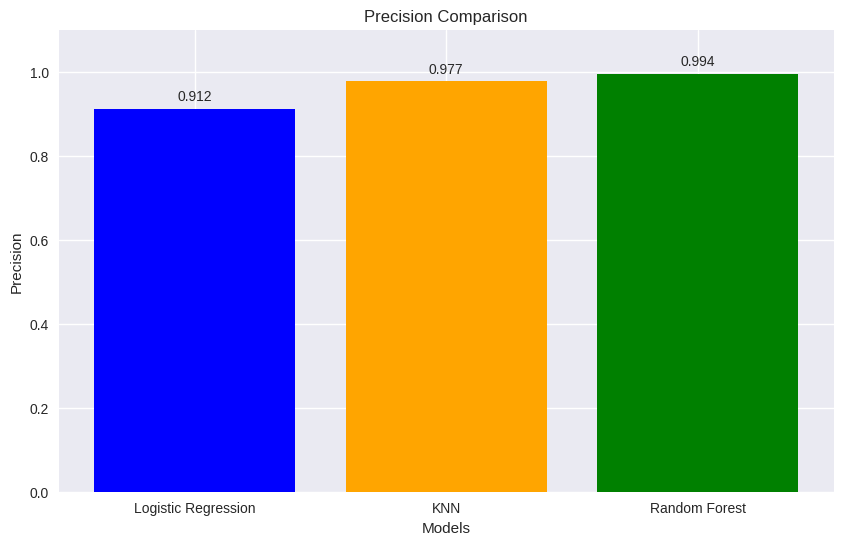

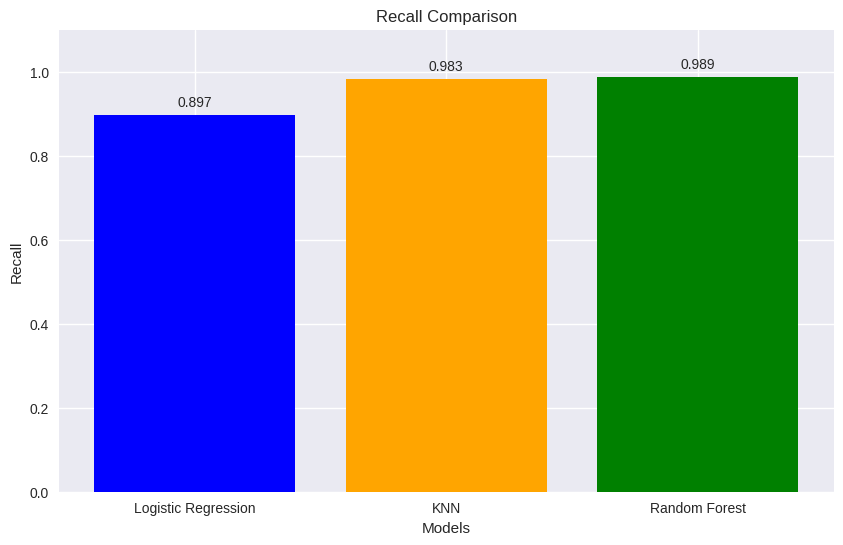

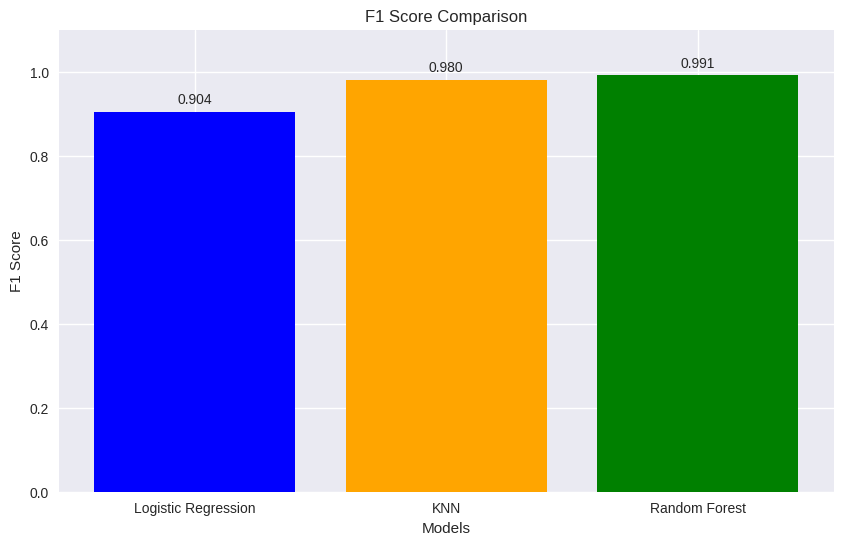

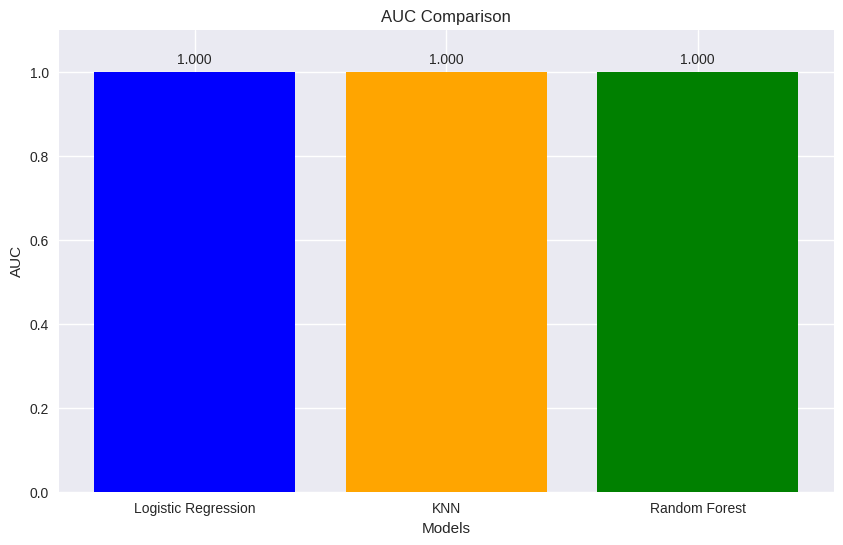

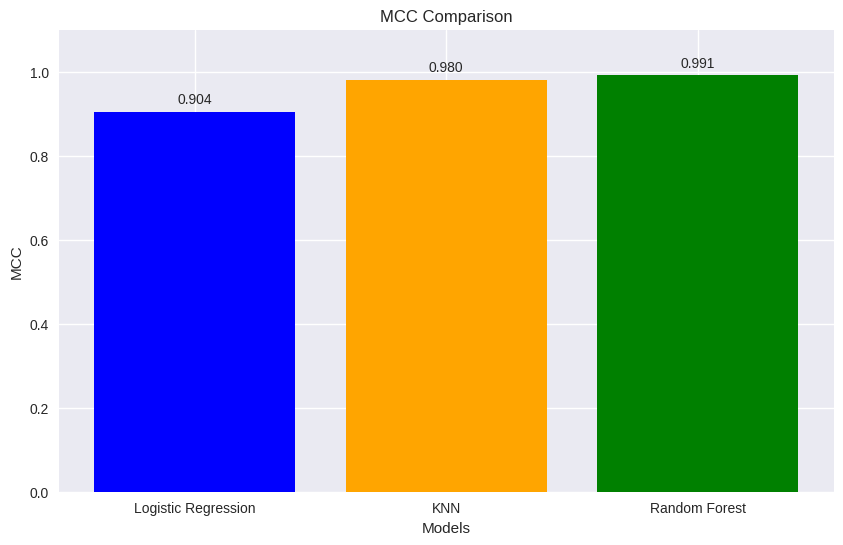


All plots generated successfully.


In [3]:
# ================================================================
#      FULL PIPELINE + ALL MODELS + COMPARISON PLOTS
# ================================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors, KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, matthews_corrcoef
)
from sklearn.ensemble import RandomForestClassifier
from scipy.spatial.distance import mahalanobis

# Make plots clean
plt.style.use("seaborn-v0_8")
plt.rcParams["figure.figsize"] = (10, 6)

# ================================================================
# 1. LOAD DATA (creditcard.csv)
# ================================================================
df = pd.read_csv("/kaggle/input/creidtcard/creditcard.csv")

# Normalize Amount and Time
scaler = StandardScaler()
df['normAmount'] = scaler.fit_transform(df['Amount'].values.reshape(-1,1))
df['normTime'] = scaler.fit_transform(df['Time'].values.reshape(-1,1))
df.drop(['Amount', 'Time'], axis=1, inplace=True)

X = df.drop("Class", axis=1).values
y = df["Class"].values


# ================================================================
# 2. MAHALANOBIS-SMOTE
# ================================================================
def mahalanobis_smote(X, y, k=5, threshold=0.5):
    X_min = X[y == 1]
    cov = np.cov(X.T)
    inv_cov = np.linalg.inv(cov)

    nbrs = NearestNeighbors(n_neighbors=k).fit(X_min)
    distances, indices = nbrs.kneighbors(X_min)

    synthetic_samples = []

    for i in range(len(X_min)):
        for n_idx in indices[i]:
            x = X_min[i]
            y_n = X_min[n_idx]

            md = mahalanobis(x, y_n, inv_cov)

            if md < threshold:
                gap = np.random.rand()
                synthetic = x + gap * (y_n - x)
                synthetic_samples.append(synthetic)

    synthetic_samples = np.array(synthetic_samples)
    y_synth = np.ones(len(synthetic_samples))

    X_new = np.vstack((X, synthetic_samples))
    y_new = np.hstack((y, y_synth))

    return X_new, y_new


# ================================================================
# 3. ENN UNDERSAMPLING
# ================================================================
def enn_cleaning(X, y, k=3):
    nbrs = NearestNeighbors(n_neighbors=k+1).fit(X)
    _, indices = nbrs.kneighbors(X)

    keep = []

    for i in range(len(X)):
        neighbors = indices[i][1:]
        labels = y[neighbors]
        if np.sum(labels == y[i]) >= 2:
            keep.append(i)

    return X[keep], y[keep]


# ================================================================
# 4. APPLY SMOTE → ENN
# ================================================================
print("\nApplying Mahalanobis SMOTE...")
X_sm, y_sm = mahalanobis_smote(X, y)

print("Applying ENN cleaning...")
X_clean, y_clean = enn_cleaning(X_sm, y_sm)


# ================================================================
# 5. TRAIN TEST SPLIT
# ================================================================
X_train, X_test, y_train, y_test = train_test_split(
    X_clean, y_clean,
    test_size=0.2,
    stratify=y_clean,
    random_state=42
)


# ================================================================
# 6. MODELS
# ================================================================
models = {
    "Logistic Regression": LogisticRegression(max_iter=500, n_jobs=-1),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "Random Forest": RandomForestClassifier(
        n_estimators=500,
        n_jobs=-1,
        class_weight="balanced_subsample"
    )
}

results = {}

# Train and evaluate each model
for name, model in models.items():
    print(f"\nTraining {name}...")
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    if hasattr(model, "predict_proba"):
        y_prob = model.predict_proba(X_test)[:, 1]
    else:
        y_prob = y_pred

    results[name] = {
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1 Score": f1_score(y_test, y_pred),
        "AUC": roc_auc_score(y_test, y_prob),
        "MCC": matthews_corrcoef(y_test, y_pred)
    }


# ================================================================
# 7. PRINT RESULTS
# ================================================================
print("\n=================== MODEL PERFORMANCE ===================")
for model_name, metrics in results.items():
    print(f"\n--- {model_name} ---")
    for m, v in metrics.items():
        print(f"{m}: {v:.4f}")
print("==========================================================")



# ================================================================
# 8. COMPARISON PLOTS
# ================================================================
def plot_metric(metric_name):
    names = list(results.keys())
    values = [results[m][metric_name] for m in names]

    plt.bar(names, values, color=["blue","orange","green"])
    plt.title(f"{metric_name} Comparison")
    plt.ylabel(metric_name)
    plt.xlabel("Models")
    plt.ylim(0, 1.1)
    for i, v in enumerate(values):
        plt.text(i, v + 0.02, f"{v:.3f}", ha='center')
    plt.show()


# Generate all plots
plot_metric("Accuracy")
plot_metric("Precision")
plot_metric("Recall")
plot_metric("F1 Score")
plot_metric("AUC")
plot_metric("MCC")

print("\nAll plots generated successfully.")


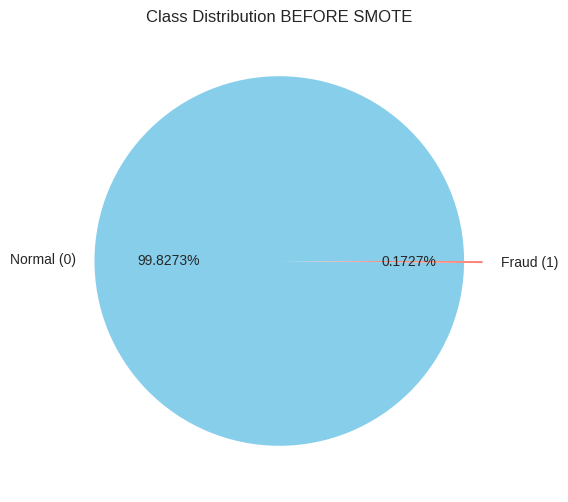

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# Count class distribution
class_counts = df['Class'].value_counts()

# Pie chart before SMOTE
plt.figure(figsize=(6,6))
plt.pie(class_counts, 
        labels=['Normal (0)', 'Fraud (1)'], 
        autopct='%1.4f%%',
        colors=['skyblue', 'salmon'],
        explode=[0, 0.1])
plt.title("Class Distribution BEFORE SMOTE")
plt.show()


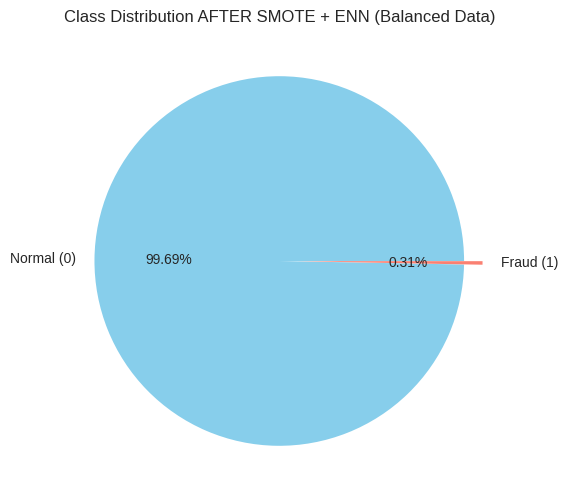

In [8]:
# Count class distribution AFTER SMOTE + ENN
after_counts = pd.Series(y_clean).value_counts()

plt.figure(figsize=(6,6))
plt.pie(after_counts, 
        labels=['Normal (0)', 'Fraud (1)'], 
        autopct='%1.2f%%',
        colors=['skyblue', 'salmon'],
        explode=[0, 0.1])
plt.title("Class Distribution AFTER SMOTE + ENN (Balanced Data)")
plt.show()


In [9]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns



================ Logistic Regression ================

Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     56842
         1.0       0.91      0.90      0.90       174

    accuracy                           1.00     57016
   macro avg       0.96      0.95      0.95     57016
weighted avg       1.00      1.00      1.00     57016


Confusion Matrix:
[[56827    15]
 [   18   156]]


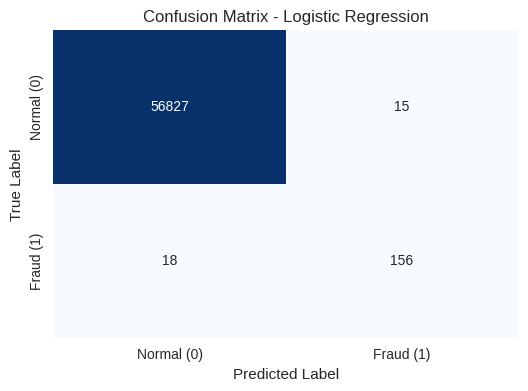


================ KNN ================

Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     56842
         1.0       0.98      0.98      0.98       174

    accuracy                           1.00     57016
   macro avg       0.99      0.99      0.99     57016
weighted avg       1.00      1.00      1.00     57016


Confusion Matrix:
[[56838     4]
 [    3   171]]


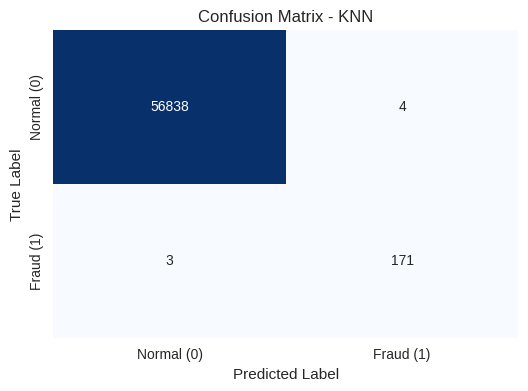


================ Random Forest ================

Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     56842
         1.0       0.99      0.99      0.99       174

    accuracy                           1.00     57016
   macro avg       0.99      0.99      0.99     57016
weighted avg       1.00      1.00      1.00     57016


Confusion Matrix:
[[56840     2]
 [    2   172]]


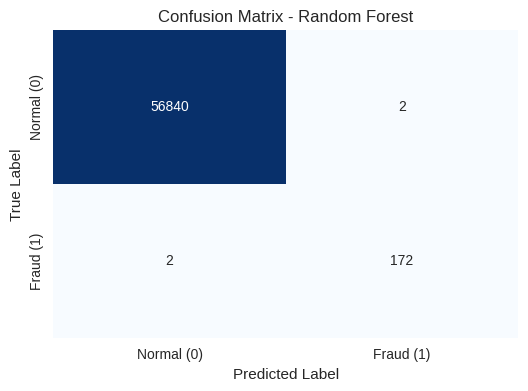

In [10]:
for name, model in models.items():
    print(f"\n================ {name} ================")
    
    y_pred = model.predict(X_test)

    # Classification Report
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    print("\nConfusion Matrix:")
    print(cm)
    
    # Plot Confusion Matrix
    plt.figure(figsize=(6,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Normal (0)', 'Fraud (1)'],
                yticklabels=['Normal (0)', 'Fraud (1)'])
    plt.title(f'Confusion Matrix - {name}')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()


In [14]:
!pip install scikit-learn==1.3.2 --quiet
!pip install imbalanced-learn==0.11.0 --quiet


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 48.2 MB/s eta 0:00:0000:010:01
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
imbalanced-learn 0.14.0 requires scikit-learn<2,>=1.4.2, but you have scikit-learn 1.3.2 which is incompatible.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.
umap-learn 0.5.9.post2 requires scikit-learn>=1.6, but you have scikit-learn 1.3.2 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.6/235.6 kB 7.3 MB/s eta 0:00:00



Applying Mahalanobis SMOTE...
Applying ENN cleaning...

----- Training Logistic Regression -----

----- Training KNN -----

----- Training Random Forest -----

----- Training Naive Bayes -----

----- Training AdaBoost -----

----- Training XGBoost (Delta Addition) -----

==================== FINAL RESULTS ====================

Logistic Regression
Accuracy: 0.9995
Precision: 0.9259
Recall: 0.9259
F1 Score: 0.9259
AUC: 0.9998
MCC: 0.9257

KNN
Accuracy: 0.9999
Precision: 0.9791
Recall: 0.9894
F1 Score: 0.9842
AUC: 1.0000
MCC: 0.9842

Random Forest
Accuracy: 0.9999
Precision: 0.9842
Recall: 0.9894
F1 Score: 0.9868
AUC: 1.0000
MCC: 0.9868

Naive Bayes
Accuracy: 0.9817
Precision: 0.1498
Recall: 0.9683
F1 Score: 0.2594
AUC: 0.9933
MCC: 0.3770

AdaBoost
Accuracy: 0.9999
Precision: 0.9947
Recall: 0.9894
F1 Score: 0.9920
AUC: 1.0000
MCC: 0.9920

XGBoost (Delta Addition)
Accuracy: 0.9999
Precision: 0.9947
Recall: 0.9894
F1 Score: 0.9920
AUC: 1.0000
MCC: 0.9920


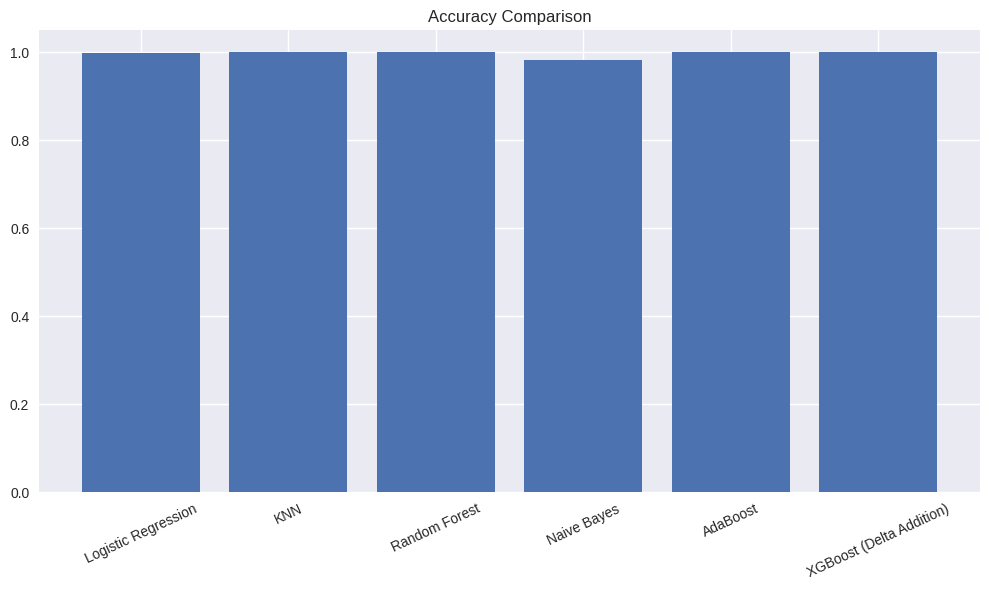

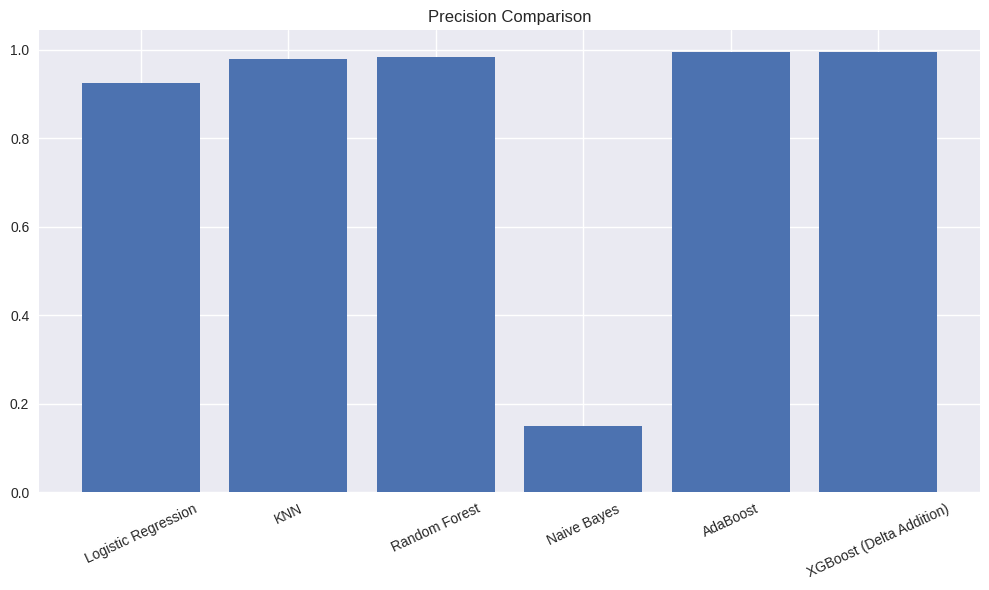

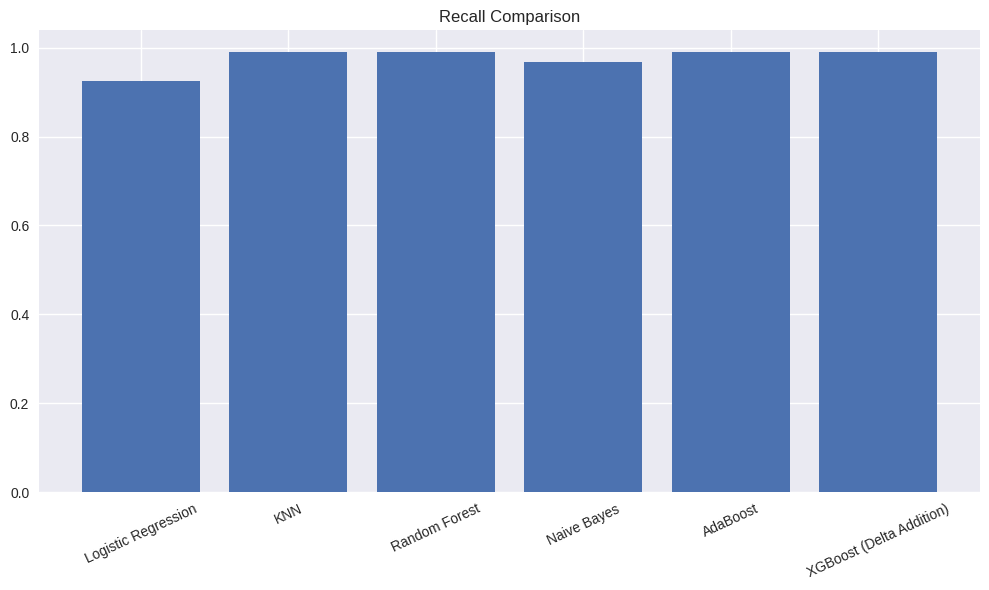

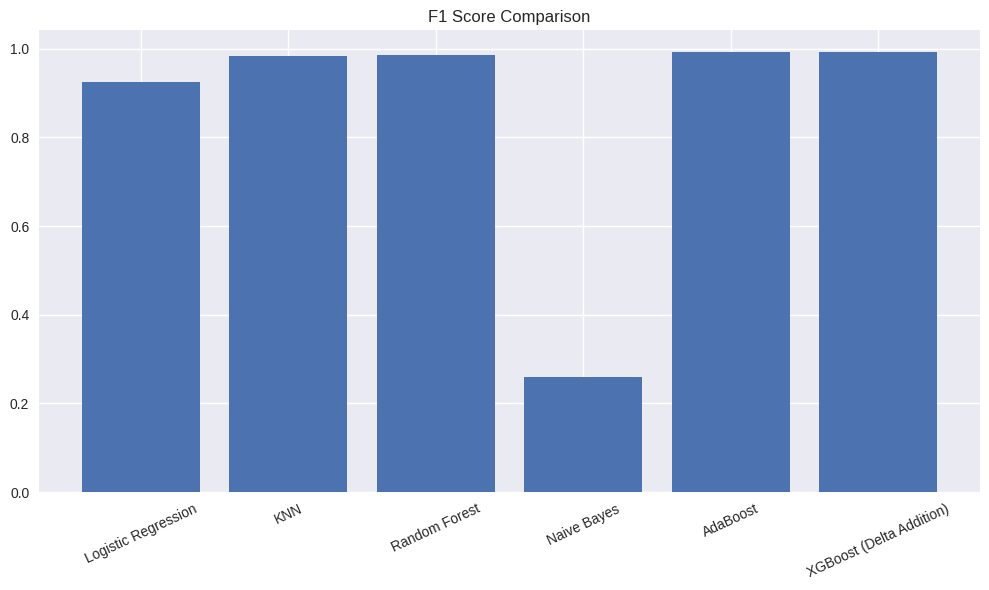

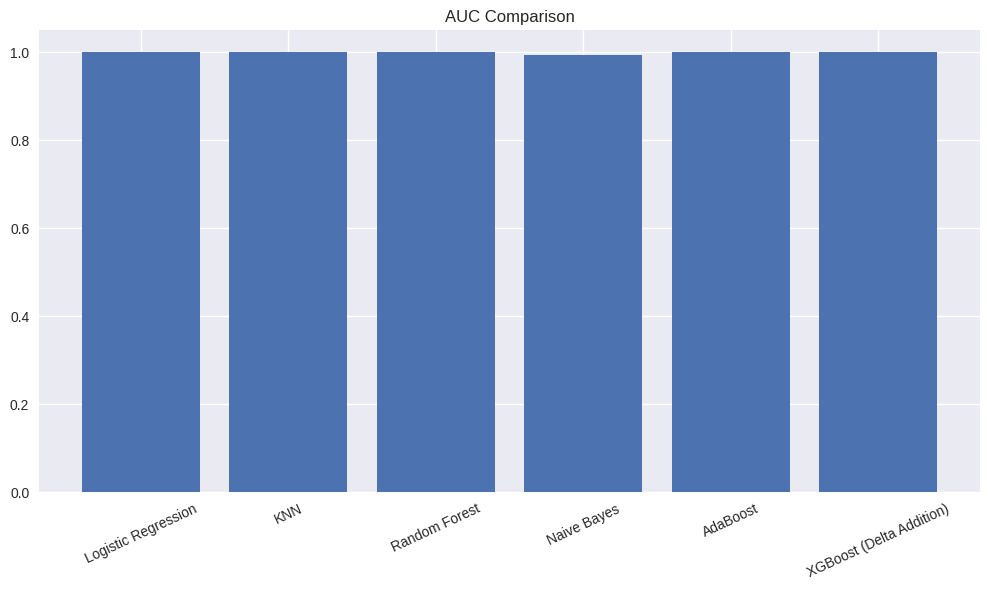

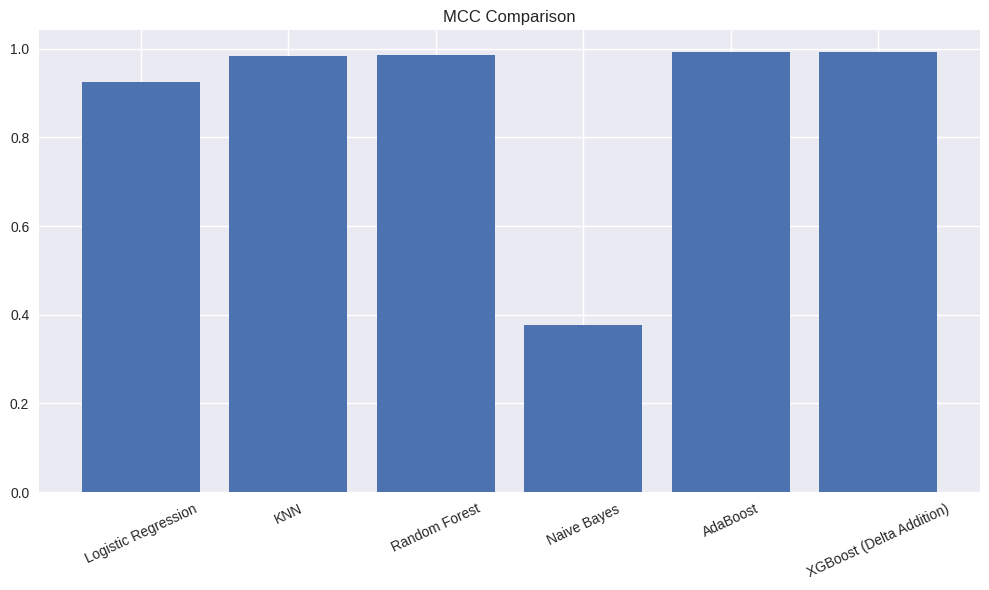

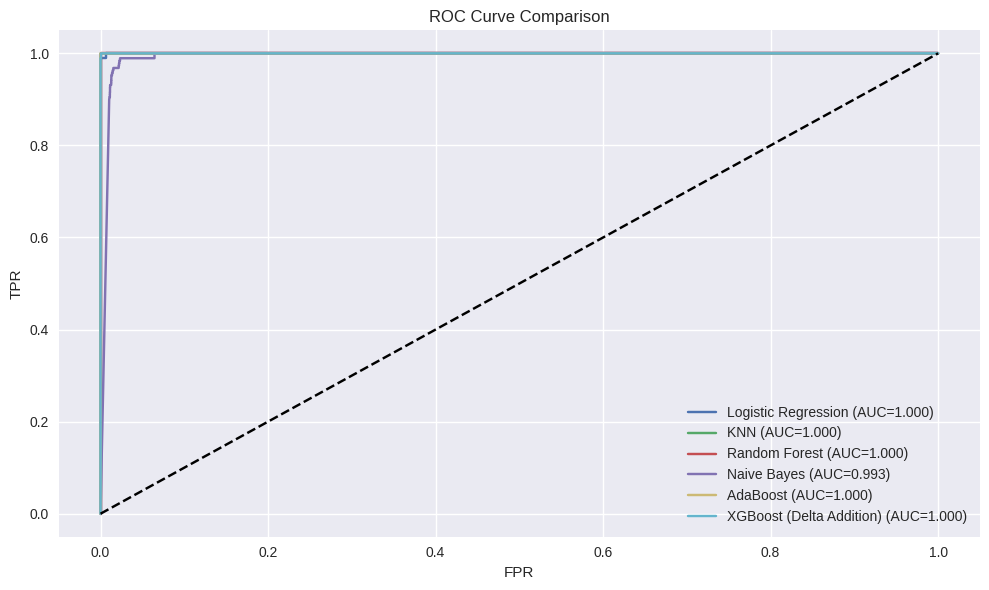

All plots generated successfully.


In [5]:
# ================================================================
#      FULL PIPELINE: MAHALANOBIS SMOTE-ENN + ALL MODELS (+ XGBOOST)
# ================================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors, KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import (
    RandomForestClassifier,
    AdaBoostClassifier
)
from sklearn.naive_bayes import GaussianNB

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, matthews_corrcoef,
    roc_curve
)

from scipy.spatial.distance import mahalanobis

# --- DELTA ADDITION MODEL ---
from xgboost import XGBClassifier  # NEW MODEL (Not in paper)

# Clean Plots
plt.style.use("seaborn-v0_8")
plt.rcParams["figure.figsize"] = (10, 6)

# ================================================================
# 1. LOAD DATA
# ================================================================
df = pd.read_csv("/kaggle/input/creidtcard/creditcard.csv")

scaler = StandardScaler()
df['normAmount'] = scaler.fit_transform(df['Amount'].values.reshape(-1,1))
df['normTime'] = scaler.fit_transform(df['Time'].values.reshape(-1,1))
df.drop(['Amount', 'Time'], axis=1, inplace=True)

X = df.drop("Class", axis=1).values
y = df["Class"].values

# ================================================================
# 2. MAHALANOBIS-SMOTE
# ================================================================
def mahalanobis_smote(X, y, k=5, threshold=0.5, random_state=42):
    rng = np.random.default_rng(random_state)

    X_min = X[y == 1]
    cov = np.cov(X_min, rowvar=False)
    inv_cov = np.linalg.pinv(cov)

    nbrs = NearestNeighbors(n_neighbors=k).fit(X_min)
    _, indices = nbrs.kneighbors(X_min)

    synthetic_samples = []

    for i in range(len(X_min)):
        x = X_min[i]
        for n_idx in indices[i]:
            y_n = X_min[n_idx]
            md = mahalanobis(x, y_n, inv_cov)

            if md < threshold:
                gap = rng.random()
                synthetic = x + gap * (y_n - x)
                synthetic_samples.append(synthetic)

    synthetic_samples = np.array(synthetic_samples)

    if len(synthetic_samples) == 0:
        return X, y

    X_new = np.vstack((X, synthetic_samples))
    y_new = np.hstack((y, np.ones(len(synthetic_samples))))

    return X_new, y_new

# ================================================================
# 3. ENN CLEANING
# ================================================================
def enn_cleaning(X, y, k=3):
    nbrs = NearestNeighbors(n_neighbors=k+1).fit(X)
    _, indices = nbrs.kneighbors(X)

    keep = []
    for i in range(len(X)):
        neighbors = indices[i][1:]
        labels = y[neighbors]
        if np.sum(labels == y[i]) >= 2:
            keep.append(i)

    return X[keep], y[keep]


# ================================================================
# 4. SMOTE → ENN
# ================================================================
print("\nApplying Mahalanobis SMOTE...")
X_sm, y_sm = mahalanobis_smote(X, y)

print("Applying ENN cleaning...")
X_clean, y_clean = enn_cleaning(X_sm, y_sm)

# ================================================================
# 5. TRAIN / TEST SPLIT
# ================================================================
X_train, X_test, y_train, y_test = train_test_split(
    X_clean, y_clean,
    test_size=0.2,
    stratify=y_clean,
    random_state=42
)

# ================================================================
# 6. MODELS (INCLUDING DELTA ADDITION: XGBOOST)
# ================================================================
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, n_jobs=-1),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "Random Forest": RandomForestClassifier(
        n_estimators=500, n_jobs=-1, class_weight="balanced_subsample"
    ),
    "Naive Bayes": GaussianNB(),
    "AdaBoost": AdaBoostClassifier(
        n_estimators=200, learning_rate=0.5
    ),

    # ---------- DELTA ADDITION ----------
    "XGBoost (Delta Addition)": XGBClassifier(
        n_estimators=300,
        learning_rate=0.1,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        eval_metric="logloss",
        n_jobs=-1
    )
}

results = {}
roc_data = {}

# ================================================================
# 7. TRAIN & EVALUATE
# ================================================================
for name, model in models.items():
    print(f"\n----- Training {name} -----")
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    y_score = model.predict_proba(X_test)[:, 1]

    acc  = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec  = recall_score(y_test, y_pred)
    f1   = f1_score(y_test, y_pred)
    auc  = roc_auc_score(y_test, y_score)
    mcc  = matthews_corrcoef(y_test, y_pred)

    results[name] = {
        "Accuracy": acc, "Precision": prec, "Recall": rec,
        "F1 Score": f1, "AUC": auc, "MCC": mcc
    }

    fpr, tpr, _ = roc_curve(y_test, y_score)
    roc_data[name] = (fpr, tpr, auc)

# ================================================================
# 8. PRINT SUMMARY
# ================================================================
print("\n==================== FINAL RESULTS ====================")
for model, metrics in results.items():
    print(f"\n{model}")
    for m, v in metrics.items():
        print(f"{m}: {v:.4f}")

# ================================================================
# 9. PLOTS
# ================================================================
def plot_metric(metric):
    names = list(results.keys())
    values = [results[n][metric] for n in names]

    plt.figure()
    plt.bar(names, values)
    plt.xticks(rotation=25)
    plt.title(f"{metric} Comparison")
    plt.tight_layout()
    plt.show()

plot_metric("Accuracy")
plot_metric("Precision")
plot_metric("Recall")
plot_metric("F1 Score")
plot_metric("AUC")
plot_metric("MCC")

plt.figure()
for name, (fpr, tpr, auc) in roc_data.items():
    plt.plot(fpr, tpr, label=f"{name} (AUC={auc:.3f})")

plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC Curve Comparison")
plt.legend()
plt.tight_layout()
plt.show()

print("All plots generated successfully.")
